# **Model evaluation**

In [2]:
import json
import joblib

# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics

In [3]:
pickles = joblib.load("../datasets/for_evaluation.joblib")

/home/mert/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:53:55] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [5]:
rf = pickles["rf_best"]
xgb = pickles["xgb_best"]
X_val = pickles["X_val"]
y_val = pickles["y_val"]
X_test= pickles["X_test"] 
y_test= pickles["y_test"]

In [6]:
ypredVal = rf.predict(X_val)
ypredVal

array([0., 1., 1., ..., 0., 1., 0.])

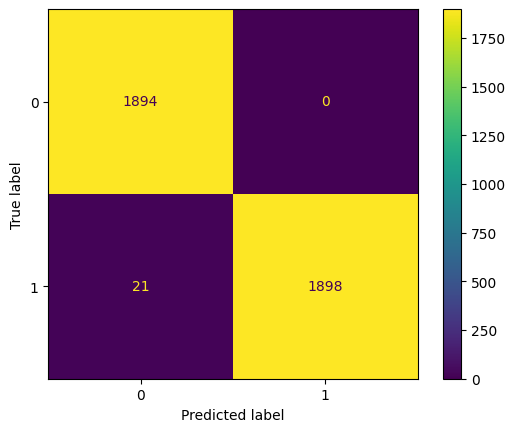

In [7]:
cm_rf = metrics.confusion_matrix(y_val,ypredVal)

disp_rf = metrics.ConfusionMatrixDisplay(cm_rf)

disp_rf.plot()

In [8]:
# claims are 1 and opinions are  0
classes = ["opinion", "claim"]

print(metrics.classification_report(y_val,ypredVal,target_names=classes, digits=5))

              precision    recall  f1-score   support

     opinion    0.98903   1.00000   0.99449      1894
       claim    1.00000   0.98906   0.99450      1919

    accuracy                        0.99449      3813
   macro avg    0.99452   0.99453   0.99449      3813
weighted avg    0.99455   0.99449   0.99449      3813



#### **XGBoost**

In [9]:
ypredValXG = xgb.predict(X_val)
ypredValXG

array([0, 1, 1, ..., 0, 1, 0])

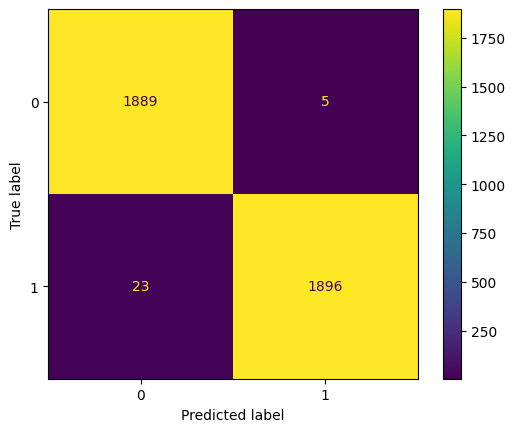

In [10]:
cm_xgb = metrics.confusion_matrix(y_val,ypredValXG)

disp_xgb = metrics.ConfusionMatrixDisplay(cm_xgb)

disp_xgb.plot()

In [11]:
print(metrics.classification_report(y_val,ypredValXG,target_names=classes, digits=5))

              precision    recall  f1-score   support

     opinion    0.98797   0.99736   0.99264      1894
       claim    0.99737   0.98801   0.99267      1919

    accuracy                        0.99266      3813
   macro avg    0.99267   0.99269   0.99266      3813
weighted avg    0.99270   0.99266   0.99266      3813



In [12]:
val_results = pd.DataFrame({"model":["Random Forest","XGBoost"],
                      "recall":[metrics.recall_score(y, y_pred) for y, y_pred in [(y_val,ypredVal),(y_val,ypredValXG)]],
                      "accuracy": [metrics.accuracy_score(y, y_pred) for y, y_pred in [(y_val,ypredVal),(y_val,ypredValXG)]]
                      })
val_results[["recall", "accuracy"]] = val_results[["recall", "accuracy"]].map(lambda x: f"{x*100:.1f}%")
val_results

,model,recall,accuracy
0,Random Forest,98.9%,99.4%
1,XGBoost,98.8%,99.3%


XGBoost has a recall of 98.8% of predicting wether a report is a claim and <br>
**RandomForest** is slightly better with 98.9% on the validation dataset that is 20% of the entire sample.

### **Predict test data with champion model (Random Forest)**

In [13]:
final_ypred = rf.predict(X_test)
final_ypred

array([1., 0., 0., ..., 1., 1., 1.])

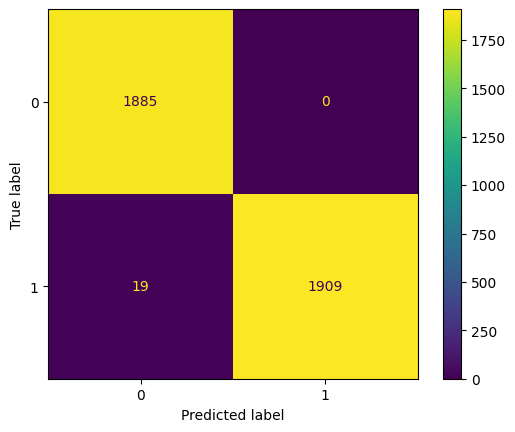

In [14]:
cm_final = metrics.confusion_matrix(y_test,final_ypred)

disp_final = metrics.ConfusionMatrixDisplay(cm_final)

disp_final.plot()

In [15]:
print(metrics.classification_report(y_test,final_ypred,target_names=classes, digits=5))

              precision    recall  f1-score   support

     opinion    0.99002   1.00000   0.99499      1885
       claim    1.00000   0.99015   0.99505      1928

    accuracy                        0.99502      3813
   macro avg    0.99501   0.99507   0.99502      3813
weighted avg    0.99507   0.99502   0.99502      3813



**The Random Forest model performs with a recall of 99.0% and an accuracy of 99.5%.**

In [16]:
# export the champion model for further use

joblib.dump(rf, "../datasets/best_model.joblib")

['../datasets/best_model.joblib']

#### **Feature importances of champion model**


In [ ]:
importances = rf.feature_importances_
importances_list = pd.Series(importances, index=X_test.columns)
importances_list = importances_list.sort_values(ascending=False)

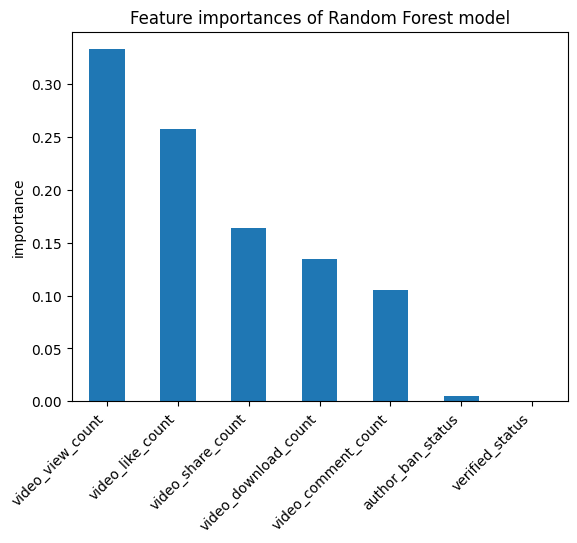

In [ ]:
importances_list.plot.bar()
plt.title("Feature importances of Random Forest model")
plt.ylabel("importance")
plt.xticks(rotation=45, ha="right")
plt.show()

It is really important to understand the nature of machine learning models when using the trained model with new data. When prediciting the claim status of videos that are new to the model, the performance rates will differ to the scored rates in the test dataset. That means that new datasets **can be predicted incorrectly** more frequently. That can be due to the sample data set that is given for this project which is **not representative for the entire population** of video creator. <br>
For example lets assume that the sample data of 20000 reports is from the year 2022 and at this time only people with age of 18 or older could upload videos. But now in 2023 the policy changed and everyone with age 12 or older can upload videos. The population of video creator changed and the sample is not representative anymore. <br>
The **Random Forest model** performed very good with an accuracy of 99.5% and a **recall of 99.0%** on the test dataset. So it can be used to determine whether a video contains claims or opinions.<br> 
Either the model can be used only on videos that are being reported or on all videos at given interval (e.g. every day) until the video has been checked a certain number of times. The second option ensures prevention of reports due to regular automated claim checks by the model. That would decrease the backlog of reports even more. This automated claim check algorithm is a possible next step. <br> 
**My recommendation** is to use the model to check incoming reports first and if the backlog is still too overloaded then I recommend to develop the automated claim check algorithm to further reduce the backlog of reports.